In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy import wcs
from scipy.spatial import KDTree
from astropy.io import fits
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from regions import Region
from spectral_cube import SpectralCube
from astroquery.jplspec import JPLSpec
from astroquery.linelists.cdms import CDMS
from astroquery.splatalogue import Splatalogue
from dust_extinction.averages import RL85_MWGC, RRP89_MWGC, B92_MWAvg, I05_MWAvg, CT06_MWLoc, CT06_MWGC, GCC09_MWAvg, F11_MWGC, G21_MWAvg, D22_MWAvg
from importlib import reload
from astropy.visualization import simple_norm

In [2]:
%cd ..
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm
import co_ice as co_map
reload(ex)
reload(co_map)
%cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [3]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

# Mass over rectangle

## CO

In [4]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [5]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

## Strong et al 1988 X-Factor

In [6]:
subcube_12CO = cube_12CO.subcube_from_regions([reg])
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

In [7]:
np.nanmax(subcube_12CO)

10.807621

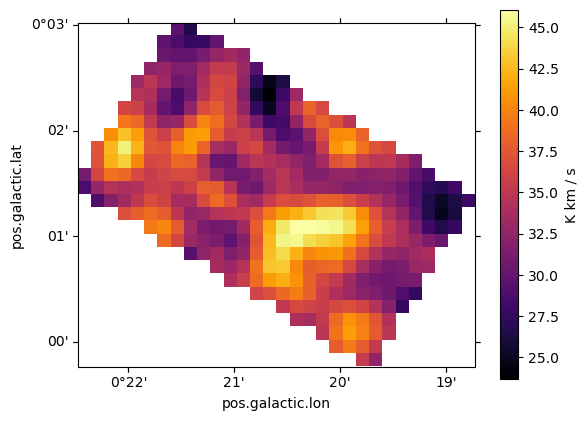

In [8]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_12CO_mom0.unit)

In [9]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
mass_Xfactor = (subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)
mass_Xfactor

<Quantity 2368.65646623 solMass>

In [10]:
ww.proj_plane_pixel_scales()[0].to(u.arcsec)

<Quantity 7.4988 arcsec>

In [11]:
coldens_Xfactor = np.nanmean(subcube_12CO_mom0)* 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
coldens_Xfactor

<Projection 8.02938156e+21 1 / cm2>

In [12]:
coldens_Xfactor_err = np.sqrt((np.nanstd(subcube_12CO_mom0)/np.nanmean(subcube_12CO_mom0))**2 + (0.3/2.3)**2)*coldens_Xfactor
coldens_Xfactor_err

<Projection 1.45755394e+21 1 / cm2>

In [13]:
mass_Xfactor_err = np.sqrt((coldens_Xfactor_err/coldens_Xfactor)**2)*mass_Xfactor
mass_Xfactor_err

<Projection 429.97639769 solMass>

## Isotopologue Masses

In [14]:
# Planck Function for blackbody radiation
def planck(T, nu):
    return (const.h*nu/const.k_B)/(np.exp(const.h*nu/(const.k_B*T))-1)

def get_S(J):
    return J / (2*J + 1)

def get_Qrot(Tex, B):
    return (const.k_B * Tex) / (const.h * B) + 1/3 

def query_JLP(mol):
    response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                                   max_frequency=1000 * u.GHz,
                                   min_strength=-500,
                                   molecule=mol,
                                   get_query_payload=False)
    return response

def query_CDMS(mol):
    response = CDMS.query_lines(min_frequency=100 * u.GHz,
                                max_frequency=1000 * u.GHz,
                                min_strength=-500,
                                molecule=mol,#"028503 CO",
                                get_query_payload=False)
    return response

def query_splat(mol):
    return Splatalogue.query_lines(1*u.mm, 3*u.mm, chemical_name=mol, energy_type='eu_k', only_NRAO_recommended=True, energy_max=50)[0]

In [15]:
mol = '030502 CO-18'#'029501 C-13-O'
query_CDMS(mol)

FREQ,ERR,LGINT,DR,ELO,GUP,MOLWT,TAG,QNFMT,Ju,Ku,vu,F1u,F2u,F3u,Jl,Kl,vl,F1l,F2l,F3l,name,Lab
MHz,MHz,nm2 MHz,,1 / cm,,u,,,,,,,,,,,,,,,,
float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str5,bool
109782.1757,0.0001,-5.0708,2,0.0,3,30,502,101,1,--,--,--,--,--,0,--,--,--,--,--,CO-18,False
219560.3577,0.0003,-4.1794,2,3.6619,5,30,502,101,2,--,--,--,--,--,1,--,--,--,--,--,CO-18,False
329330.5523,0.0003,-3.6706,2,10.9857,7,30,502,101,3,--,--,--,--,--,2,--,--,--,--,--,CO-18,False
439088.766,0.0004,-3.3231,2,21.971,9,30,502,101,4,--,--,--,--,--,3,--,--,--,--,--,CO-18,False
548831.0057,0.0005,-3.0675,2,36.6174,11,30,502,101,5,--,--,--,--,--,4,--,--,--,--,--,CO-18,False
658553.2788,0.0007,-2.8728,2,54.9244,13,30,502,101,6,--,--,--,--,--,5,--,--,--,--,--,CO-18,False
768251.593,0.001,-2.7226,2,76.8914,15,30,502,101,7,--,--,--,--,--,6,--,--,--,--,--,CO-18,False
877921.9569,0.0015,-2.6071,2,102.5175,17,30,502,101,8,--,--,--,--,--,7,--,--,--,--,--,CO-18,False


In [16]:
co_abundance = 10**(-4)

### 13CO

In [17]:
def get_13CO_10_N(Tex, I, Ju=1):
    mu = (1.1046*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 55101.011 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    #jpl = query_JLP("29001 C-13-O")
    #freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    cdms = query_CDMS('029501 C-13-O')
    freq = (cdms['FREQ']).to(u.GHz)[Ju-1]
    splat = query_splat(' 13CO ')
    #freq = splat['orderedfreq']*u.MHz
    Eu = splat['upper_state_energy_K'] * u.K
    gu = cdms['GUP'][Ju-1]
    #gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1)
    N = N*I

    return N.to(u.cm**(-2))

In [18]:
subcube_13CO = cube_13CO.subcube_from_regions([reg])
subcube_13CO = subcube_13CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_13CO_mom0 = subcube_13CO.moment0()

In [19]:
column_density_13CO = get_13CO_10_N(10*u.K, subcube_13CO_mom0)

In [20]:
ratio_12C_13C = 53 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_13CO_mom0.header)
N_13CO = np.nansum(column_density_13CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_13CO = N_13CO * pixel_physical_area * 2.8 * u.Da
mass_13CO = M_13CO.to(u.M_sun) * ratio_12C_13C / co_abundance
mass_13CO

<Quantity 847.88678304 solMass>

In [21]:
ratio_12C_13C_GC = 20 # from Wilson & Rood 1994
mass_13CO_GC = M_13CO.to(u.M_sun) * ratio_12C_13C_GC / co_abundance
mass_13CO_GC

<Quantity 319.95727662 solMass>

In [22]:
coldens_13CO = np.nanmean(column_density_13CO) * ratio_12C_13C / co_abundance
coldens_13CO

<Projection 2.87420606e+21 1 / cm2>

In [23]:
coldens_13CO_err = coldens_13CO*(np.nanstd(subcube_13CO_mom0)/np.nanmean(subcube_13CO_mom0))
coldens_13CO_err

<Projection 5.29337112e+20 1 / cm2>

In [24]:
mass_13CO_err = mass_13CO * coldens_13CO_err / coldens_13CO
mass_13CO_err

<Projection 156.15371079 solMass>

### C18O

In [25]:
def get_C18O_10_N(Tex, I, Ju=1):
    mu = (1.1079*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 54891.420 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    #jpl = query_JLP("29001 CO-18")
    #freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    cdms = query_CDMS('030502 CO-18')
    freq = (cdms['FREQ']).to(u.GHz)[Ju-1]
    splat = query_splat(' C18O ')
    Eu = splat['upper_state_energy_K'] * u.K
    #gu = jpl['GUP'][Ju-1]
    gu = cdms['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1) 
    N = N*I

    return N.to(u.cm**(-2))

In [26]:
subcube_C18O = cube_C18O.subcube_from_regions([reg])
subcube_C18O = subcube_C18O.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_C18O_mom0 = subcube_C18O.moment0()

In [27]:
column_density_C18O = get_C18O_10_N(10*u.K, subcube_C18O_mom0)

In [28]:
ratio_16O_18O = 327 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_C18O_mom0.header)
N_C18O = np.nansum(column_density_C18O.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_C18O = N_C18O * pixel_physical_area * 2.8 * u.Da
mass_C18O = M_C18O.to(u.M_sun) * ratio_16O_18O / co_abundance
mass_C18O

<Quantity 2557.54240325 solMass>

In [29]:
ratio_16O_18O_GC = 250 # from Wilson & Rood 1994
mass_C18O_GC = M_C18O.to(u.M_sun) * ratio_16O_18O_GC / co_abundance
mass_C18O_GC

<Quantity 1955.30764775 solMass>

In [30]:
coldens_C18O = np.nanmean(column_density_C18O) * ratio_16O_18O / co_abundance
coldens_C18O

<Projection 8.6696762e+21 1 / cm2>

In [31]:
coldens_C18O_err = coldens_C18O*(np.nanstd(subcube_C18O_mom0)/np.nanmean(subcube_C18O_mom0))
coldens_C18O_err

<Projection 3.52147048e+21 1 / cm2>

In [32]:
mass_C18O_err = mass_C18O * coldens_C18O_err / coldens_C18O
mass_C18O_err

<Projection 1038.82888521 solMass>

## Extinction Mass

In [33]:
av_map = fits.open('/orange/adamginsburg/jwst/cloudc/images/filament_av_map.fits')[0]
ww_ext = wcs.WCS(av_map.header)
mass_extinction = ex.get_mass_estimate(av_map.data, ww_ext, dist=5*u.kpc, mpp=2.8*u.u)
mass_extinction

<Quantity 6039.59159522 solMass>

In [34]:
mass_extinction_err = 0 * u.Msun
mass_extinction_err

<Quantity 0. solMass>

In [35]:
coldens_extinction = np.nanmean(av_map.data) * 2*10**21*u.cm**-2
coldens_extinction

<Quantity 4.03881604e+22 1 / cm2>

In [36]:
coldens_extinction_err = np.nanstd(av_map.data) * 2*10**21*u.cm**-2
coldens_extinction_err

<Quantity 3.09534428e+22 1 / cm2>

## PPMAP

In [37]:
ppmap = '/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_cdens.fits'

In [38]:
r0 = reg#[0]
hdul = fits.open(ppmap)
ww = wcs.WCS(hdul[0].header)
preg = r0.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(hdul[0].data)
#pixelarea = 1*u.pixel
cden = (mask.multiply(hdul[0].data) * (10**20) * u.cm**(-2))
        #* u.Unit(hdul[0].header['BUNIT']))
u.Unit(hdul[0].header['BUNIT'])

Unit("1e+20 / cm2")

In [39]:
coldens_ppmap = np.nanmean(cden)
coldens_ppmap

<Quantity 2.44691751e+22 1 / cm2>

In [40]:
pix_area_2 = ww.celestial.proj_plane_pixel_area()
pix_area_cm_2 = (pix_area_2 * (5*u.kpc)**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)
mass_ppmap = (pix_area_cm_2 * cden * u.Da*2.8).to(u.M_sun).sum()
mass_ppmap

<Quantity 15287.31118604 solMass>

In [41]:
coldens_ppmap_err = mask.multiply(fits.open('/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_sigdiffcdens.fits')[0].data[5]).mean()* (10**20) * u.cm**(-2)#*u.Unit(hdul[0].header['BUNIT'])
coldens_ppmap_err 

<Quantity 4.14044193e+20 1 / cm2>

In [42]:
mass_ppmap_err = mass_ppmap * coldens_ppmap_err / coldens_ppmap
mass_ppmap_err

<Quantity 258.67739222 solMass>

## CO Ice

In [3]:
co_col = fits.open('/orange/adamginsburg/jwst/cloudc/images/filament_co_ice_col_map_fwhm15.fits')[0]
co_column_map = co_col.data
ww_co = wcs.WCS(co_col.header)

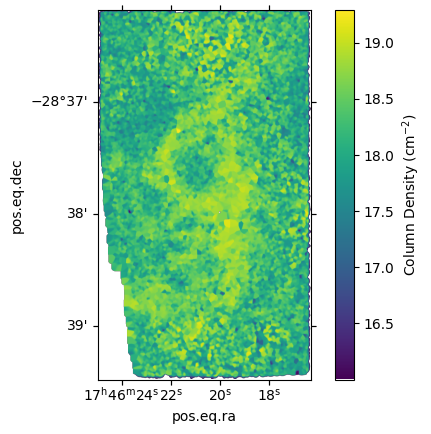

In [4]:
ax = plt.subplot(projection=ww_co)
im = ax.imshow(np.log10(co_column_map), origin='lower')
plt.colorbar(im, label='Column Density (cm$^{-2}$)')

In [5]:
co_abundance = 10**(-4)
pixel_area_physical = (ww_co.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
mpp = 2.8*u.Da
# grid_interp = N(CO) map after interpolation
mass_co_ice = (np.nansum(co_column_map) * u.cm**(-2) * pixel_area_physical * mpp / co_abundance).to(u.Msun)
mass_co_ice

<Quantity 7301.03172314 solMass>

In [6]:
mass_co_ice_err = 0*u.Msun
mass_co_ice_err

<Quantity 0. solMass>

In [7]:
coldens_co_ice = np.nanmean(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice

<Quantity 2.65564614e+22 1 / cm2>

In [8]:
coldens_co_ice_err = np.nanstd(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice_err

<Quantity 2.15146566e+22 1 / cm2>

## Mass Table

In [49]:
methods = ['A$_V times 2e21$', '$^{12}CO$ X-factor', '$^{13}$CO LTE', 'C$^{18}$O LTE', 'PPMAP', 'CO Ice']
masses = [mass_extinction, mass_Xfactor, mass_13CO, mass_C18O, mass_ppmap, mass_co_ice]
masses_err = [mass_extinction_err, mass_Xfactor_err, mass_13CO_err, mass_C18O_err, mass_ppmap_err, mass_co_ice_err]
coldens = [coldens_extinction, coldens_Xfactor, coldens_13CO, coldens_C18O, coldens_ppmap, coldens_co_ice]
coldens_err = [coldens_extinction_err, coldens_Xfactor_err, coldens_13CO_err, coldens_C18O_err, coldens_ppmap_err, coldens_co_ice_err]

column_names = ['Method', 'Mass', 'Mass Error', 'Column Density', 'Column Density Error']

In [50]:
masses_n = masses.copy()
masses_err_n = masses_err.copy()
coldens_n = coldens.copy()
coldens_err_n = coldens_err.copy()
for i in range(len(methods)):
    print(methods[i], masses[i], masses_err[i], coldens[i]*10**22, coldens_err[i]*10**22)
    masses_n[i] = int(masses[i].value)*u.M_sun
    masses_err_n[i] = int(masses_err[i].value)*u.M_sun
    coldens_n[i] = np.round(coldens[i].value/10**22*u.cm**-2, 2)
    coldens_err_n[i] = np.round(coldens_err[i].value/10**22*u.cm**-2, 2)

A$_V times 2e21$ 6039.5915952153755 solMass 0.0 solMass 4.0388160392326954e+44 1 / cm2 3.0953442845659577e+44 1 / cm2
$^{12}CO$ X-factor 2368.6564662298774 solMass 429.9763976879777 solMass 8.029381561279297e+43 1 / cm2 1.4575539376870044e+43 1 / cm2
$^{13}$CO LTE 847.886783041244 solMass 156.15371078505854 solMass 2.8742060567197043e+43 1 / cm2 5.293371123298195e+42 1 / cm2
C$^{18}$O LTE 2557.5424032526826 solMass 1038.8288852079013 solMass 8.669676202971022e+43 1 / cm2 3.5214704763415195e+43 1 / cm2
PPMAP 15287.311186037461 solMass 258.6773922152559 solMass 2.446917514944868e+44 1 / cm2 4.140441926176552e+42 1 / cm2
CO Ice 7302.963471347475 solMass 0.0 solMass 2.6772205926526174e+44 1 / cm2 1.718281043430283e+44 1 / cm2


In [51]:
#Total CO / Av
#Total CO / PPMAP

total_CO = mass_co_ice + mass_Xfactor
total_CO_Av = (mass_co_ice + mass_Xfactor) / mass_extinction
total_CO_PPMAP = (mass_co_ice + mass_Xfactor) / mass_ppmap
print('Total CO / A_V:', total_CO_Av)
print('Total CO / PPMAP:', total_CO_PPMAP)

Total CO / A_V: 1.6013698583922968
Total CO / PPMAP: 0.6326567059360214


In [52]:
ice_fraction = mass_co_ice / (mass_co_ice + mass_Xfactor)
print('CO Ice Fraction:', ice_fraction)

CO Ice Fraction: 0.7550920650813743


In [53]:
tbl = Table([methods, masses_n, masses_err_n, coldens_n, coldens_err_n], names=column_names)
tbl

Method,Mass,Mass Error,Column Density,Column Density Error
,solMass,solMass,1 / cm2,1 / cm2
str18,float64,float64,float64,float64
A$_V times 2e21$,6039.0,0.0,4.04,3.1
$^{12}CO$ X-factor,2368.0,429.0,0.8,0.15
$^{13}$CO LTE,847.0,156.0,0.29,0.05
C$^{18}$O LTE,2557.0,1038.0,0.87,0.35
PPMAP,15287.0,258.0,2.45,0.04
CO Ice,7302.0,0.0,2.68,1.72


In [54]:
tbl.write('masses_table_n.tex', format='ascii.latex', overwrite=True)

# Mass within region

In [10]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')

## Strong et al 1988

In [56]:
subcube_12CO = cube_12CO.subcube_from_regions(reg_f)
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

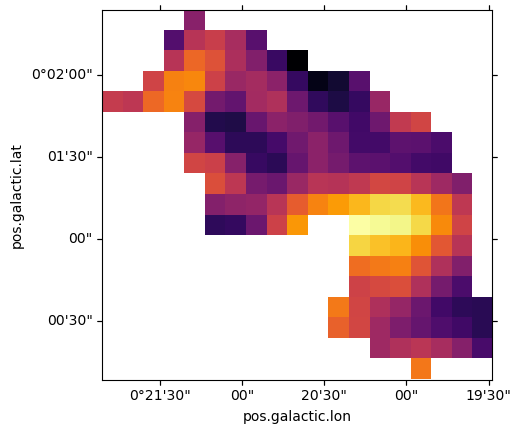

In [57]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')

In [58]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
mass_Xfactor = (subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)
mass_Xfactor

<Quantity 935.29761534 solMass>

In [59]:
coldens_Xfactor = np.nanmean(subcube_12CO_mom0)* 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
coldens_Xfactor

<Projection 8.25569218e+21 1 / cm2>

In [60]:
coldens_Xfactor_err = np.sqrt((np.nanstd(subcube_12CO_mom0)/np.nanmean(subcube_12CO_mom0))**2 + (0.3/2.3)**2)*coldens_Xfactor
coldens_Xfactor_err

<Projection 1.40741997e+21 1 / cm2>

In [61]:
mass_Xfactor_err = np.sqrt((coldens_Xfactor_err/coldens_Xfactor)**2)*mass_Xfactor
mass_Xfactor_err

<Projection 159.448356 solMass>

## Isotopologue Mass

### 13CO

In [62]:
subcube_13CO = cube_13CO.subcube_from_regions(reg_f)
subcube_13CO = subcube_13CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_13CO_mom0 = subcube_13CO.moment0()

In [63]:
column_density_13CO = get_13CO_10_N(10*u.K, subcube_13CO_mom0)

In [64]:
ratio_12C_13C = 53 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_13CO_mom0.header)
N_13CO = np.nansum(column_density_13CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_13CO = N_13CO * pixel_physical_area * 2.8 * u.Da
mass_13CO = M_13CO.to(u.M_sun) * ratio_12C_13C / co_abundance
mass_13CO

<Quantity 357.98178101 solMass>

In [65]:
ratio_12C_13C_GC = 20 # from Wilson & Rood 1994
mass_13CO_GC = M_13CO.to(u.M_sun) * ratio_12C_13C_GC / co_abundance
mass_13CO_GC

<Quantity 135.08746453 solMass>

In [66]:
coldens_13CO = np.nanmean(column_density_13CO) * ratio_12C_13C / co_abundance
coldens_13CO

<Projection 3.1598365e+21 1 / cm2>

In [67]:
coldens_13CO_err = coldens_13CO*(np.nanstd(subcube_13CO_mom0)/np.nanmean(subcube_13CO_mom0))
coldens_13CO_err

<Projection 3.51939751e+20 1 / cm2>

In [68]:
mass_13CO_err = mass_13CO * coldens_13CO_err / coldens_13CO
mass_13CO_err

<Projection 39.87168926 solMass>

### C18O

In [69]:
subcube_C18O = cube_C18O.subcube_from_regions(reg_f)
subcube_C18O = subcube_C18O.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_C18O_mom0 = subcube_C18O.moment0()

In [70]:
column_density_C18O = get_C18O_10_N(10*u.K, subcube_C18O_mom0)

In [71]:
ratio_16O_18O = 327 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_C18O_mom0.header)
N_C18O = np.nansum(column_density_C18O.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_C18O = N_C18O * pixel_physical_area * 2.8 * u.Da
mass_C18O = M_C18O.to(u.M_sun) * ratio_16O_18O / co_abundance
mass_C18O

<Quantity 1283.04039775 solMass>

In [72]:
ratio_16O_18O_GC = 250 # from Wilson & Rood 1994
mass_C18O_GC = M_C18O.to(u.M_sun) * ratio_16O_18O_GC / co_abundance
mass_C18O_GC

<Quantity 980.91773529 solMass>

In [73]:
coldens_C18O = np.nanmean(column_density_C18O) * ratio_16O_18O / co_abundance
coldens_C18O

<Projection 1.13251514e+22 1 / cm2>

In [74]:
coldens_C18O_err = coldens_C18O*(np.nanstd(subcube_C18O_mom0)/np.nanmean(subcube_C18O_mom0))
coldens_C18O_err

<Projection 2.44643275e+21 1 / cm2>

In [75]:
mass_C18O_err = mass_C18O * coldens_C18O_err / coldens_C18O
mass_C18O_err

<Projection 277.15938887 solMass>

## Extinction

In [76]:
#ext_map = ex.make_extinction_map(Av_fill=85, reg=reg_f)
#ext_map[ext_map < 1] = np.nan
#ww = ex.get_wcs()
#mass_extinction = ex.get_mass_estimate(ext_map, ww)
#mass_extinction


In [77]:
ext_map = av_map.data
reg_f_pix = reg_f[0].to_pixel(ww_ext)
mask = reg_f_pix.to_mask()
#cutout = mask.cutout(ext_map)
ext_map = mask.multiply(ext_map)
ext_map[ext_map <= 0] = np.nan
mass_extinction = ex.get_mass_estimate(ext_map, ww_ext, dist=5*u.kpc, mpp=2.8*u.u)
mass_extinction

<Quantity 3291.93090521 solMass>

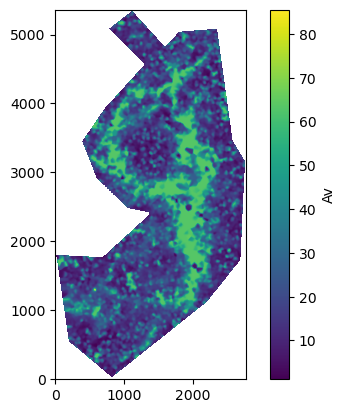

In [78]:
im = plt.imshow(ext_map, origin='lower')
plt.colorbar(im, label='Av')

In [79]:
mass_extinction_err = 0*u.Msun

In [80]:
ext_N = ext_map*2.21*10**21*u.cm**-2
coldens_extinction = np.nanmean(ext_N)
coldens_extinction

<Quantity 5.8416836e+22 1 / cm2>

In [81]:
# 2.21 +/- 0.09 x 10**21
#ext_N_CT06 = ext_map_CT06*2.21*10**21*u.cm**-2
#ext_N_F11 = ext_map_F11*2.21*10**21*u.cm**-2
#
#coldens_extinction_CT06 = np.nanmean(ext_N_CT06)
#coldens_extinction_F11 = np.nanmean(ext_N_F11)

coldens_extinction_err = np.sqrt((np.nanstd(ext_N)/np.nanmean(ext_N))**2 + (0.09/2.21)**2)*coldens_extinction
coldens_extinction_err

<Quantity 3.81689685e+22 1 / cm2>

## PPMAP

In [82]:
ppmap = '/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_cdens.fits'

In [83]:
r0 = reg_f[0]
hdul = fits.open(ppmap)
ww = wcs.WCS(hdul[0].header)
preg = r0.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(hdul[0].data)
#pixelarea = 1*u.pixel
cden = (mask.multiply(hdul[0].data) * (10**20) * u.cm**(-2))
        #* u.Unit(hdul[0].header['BUNIT']))
u.Unit(hdul[0].header['BUNIT'])

Unit("1e+20 / cm2")

In [84]:
coldens_ppmap = np.nanmean(cden)
coldens_ppmap

<Quantity 2.08165246e+22 1 / cm2>

In [85]:
pix_area_2 = ww.celestial.proj_plane_pixel_area()
pix_area_cm_2 = (pix_area_2 * (5*u.kpc)**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)
mass_ppmap = (pix_area_cm_2 * cden * u.Da*2.8).to(u.M_sun).sum()
mass_ppmap

<Quantity 5413.96636566 solMass>

In [86]:
coldens_ppmap_err = mask.multiply(fits.open('/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_sigdiffcdens.fits')[0].data[5]).mean()* (10**20) * u.cm**(-2)#*u.Unit(hdul[0].header['BUNIT'])
coldens_ppmap_err 

<Quantity 3.77682876e+20 1 / cm2>

In [87]:
mass_ppmap_err = mass_ppmap * coldens_ppmap_err / coldens_ppmap
mass_ppmap_err

<Quantity 98.22784687 solMass>

## CO Ice

In [11]:
co_col = co_col.data#.copy()
reg_f_pix = reg_f[0].to_pixel(ww_co)
mask = reg_f_pix.to_mask()
co_column_map = mask.multiply(co_column_map)

co_abundance = 10**(-4)
pixel_area_physical = (ww_co.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
mpp = 2.8*u.Da
# grid_interp = N(CO) map after interpolation
mass_co_ice = (np.nansum(co_column_map) * u.cm**(-2) * pixel_area_physical * mpp / co_abundance).to(u.Msun)
mass_co_ice

<Quantity 4053.99798616 solMass>

/scratch/local/10463474/ipykernel_1992851/3800009776.py:3: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(co_column_map), origin='lower')


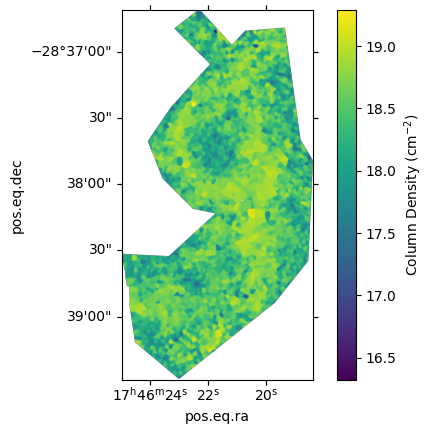

In [14]:
ax = plt.subplot(projection=ww_co)
co_column_map[co_column_map<0] = np.nan
im = ax.imshow(np.log10(co_column_map), origin='lower')
plt.colorbar(im, ax=ax, label='Column Density (cm$^{-2}$)')

In [15]:
mass_co_ice_err = 0*u.Msun

In [16]:
coldens_co_ice = np.nanmean(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice

<Quantity 2.14735369e+22 1 / cm2>

In [17]:
coldens_co_ice_err = np.nanstd(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice_err

<Quantity 2.4739288e+22 1 / cm2>

## Mass Table

In [93]:
methods = ['A$_V times 2e21$', '$^{12}CO$ X-factor', '$^{13}$CO LTE', 'C$^{18}$O LTE', 'PPMAP', 'CO Ice']
masses = [mass_extinction, mass_Xfactor, mass_13CO, mass_C18O, mass_ppmap, mass_co_ice]
masses_err = [mass_extinction_err, mass_Xfactor_err, mass_13CO_err, mass_C18O_err, mass_ppmap_err, mass_co_ice_err]
coldens = [coldens_extinction, coldens_Xfactor, coldens_13CO, coldens_C18O, coldens_ppmap, coldens_co_ice]
coldens_err = [coldens_extinction_err, coldens_Xfactor_err, coldens_13CO_err, coldens_C18O_err, coldens_ppmap_err, coldens_co_ice_err]

column_names = ['Method', 'Mass', 'Mass Error', 'Column Density', 'Column Density Error']

In [94]:
masses_n = masses.copy()
masses_err_n = masses_err.copy()
coldens_n = coldens.copy()
coldens_err_n = coldens_err.copy()

for i in range(len(methods)):
    masses_n[i] = int(masses[i].value)*u.M_sun
    masses_err_n[i] = int(masses_err[i].value)*u.M_sun
    coldens_n[i] = np.round(coldens[i].value/10**22*u.cm**-2, 2)
    coldens_err_n[i] = np.round(coldens_err[i].value/10**22*u.cm**-2, 2)
    print(methods[i], masses_n[i], masses_err_n[i], coldens_n[i]*10**22, coldens_err_n[i]*10**22)

A$_V times 2e21$ 3291.0 solMass 0.0 solMass 5.84e+22 1 / cm2 3.82e+22 1 / cm2
$^{12}CO$ X-factor 935.0 solMass 159.0 solMass 8.3e+21 1 / cm2 1.4000000000000003e+21 1 / cm2
$^{13}$CO LTE 357.0 solMass 39.0 solMass 3.2e+21 1 / cm2 4e+20 1 / cm2
C$^{18}$O LTE 1283.0 solMass 277.0 solMass 1.13e+22 1 / cm2 2.4e+21 1 / cm2
PPMAP 5413.0 solMass 98.0 solMass 2.08e+22 1 / cm2 4e+20 1 / cm2
CO Ice 4079.0 solMass 0.0 solMass 2.16e+22 1 / cm2 2.25e+22 1 / cm2


In [95]:
#Total CO / Av
#Total CO / PPMAP

total_CO = mass_co_ice + mass_Xfactor
total_CO_Av = (mass_co_ice + mass_Xfactor) / mass_extinction
total_CO_PPMAP = (mass_co_ice + mass_Xfactor) / mass_ppmap
print('Total CO / A_V:', total_CO_Av)
print('Total CO / PPMAP:', total_CO_PPMAP)

Total CO / A_V: 1.523271346176061
Total CO / PPMAP: 0.926216323269932


In [96]:
total_CO

<Quantity 5014.5040215 solMass>

In [97]:
ice_fraction = mass_co_ice / (mass_co_ice + mass_Xfactor)
print('CO Ice Fraction:', ice_fraction)

CO Ice Fraction: 0.8134815305097245


In [98]:
tbl = Table([methods, masses_n, masses_err_n, coldens_n, coldens_err_n], names=column_names)
tbl

Method,Mass,Mass Error,Column Density,Column Density Error
,solMass,solMass,1 / cm2,1 / cm2
str18,float64,float64,float64,float64
A$_V times 2e21$,3291.0,0.0,5.84,3.82
$^{12}CO$ X-factor,935.0,159.0,0.83,0.14
$^{13}$CO LTE,357.0,39.0,0.32,0.04
C$^{18}$O LTE,1283.0,277.0,1.13,0.24
PPMAP,5413.0,98.0,2.08,0.04
CO Ice,4079.0,0.0,2.16,2.25


In [99]:
tbl.write('masses_table_reg_n.tex', format='ascii.latex', overwrite=True)